In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

2025-08-04 16:32:10.469924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754325130.672631      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754325130.727665      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 1. تحميل الصور والماسكات مباشرة من المجلد الأصلي
DATA_DIR = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'
img_size = 128
image_paths, mask_paths = [], []

for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        if file.endswith('.tif') and '_mask' not in file:
            image_path = os.path.join(root, file)
            mask_path = os.path.join(root, file.replace('.tif', '_mask.tif'))
            if os.path.exists(mask_path):
                image_paths.append(image_path)
                mask_paths.append(mask_path)

print(f"✅ Total matched image-mask pairs: {len(image_paths)}")

✅ Total matched image-mask pairs: 3929


In [3]:
# 2. قراءة الصور وتحضير البيانات
X, Y = [], []

for img_path, mask_path in zip(image_paths, mask_paths):
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img is None or mask is None:
        continue

    img = cv2.resize(img, (img_size, img_size))
    mask = cv2.resize(mask, (img_size, img_size))

    X.append(img)
    Y.append(mask)

X = np.array(X, dtype=np.float32) / 255.0
Y = np.array(Y, dtype=np.float32) / 255.0
Y = np.expand_dims(Y, axis=-1)

print(f"✅ Loaded {len(X)} samples.")
print(f"Shape of images: {X.shape}, Shape of masks: {Y.shape}")

✅ Loaded 3929 samples.
Shape of images: (3929, 128, 128, 3), Shape of masks: (3929, 128, 128, 1)


In [4]:
# 3. تقسيم البيانات
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

In [5]:
# 4. دالة Dice و Loss
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [6]:
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice_loss = 1 - dice_coefficient(y_true, y_pred)
    return bce + dice_loss

In [7]:
# 5. بناء U-Net
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)

    c4 = Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)

    u5 = UpSampling2D()(c4)
    merge5 = Concatenate()([u5, c3])
    c5 = Conv2D(64, 3, activation='relu', padding='same')(merge5)
    c5 = Conv2D(64, 3, activation='relu', padding='same')(c5)

    u6 = UpSampling2D()(c5)
    merge6 = Concatenate()([u6, c2])
    c6 = Conv2D(32, 3, activation='relu', padding='same')(merge6)
    c6 = Conv2D(32, 3, activation='relu', padding='same')(c6)

    u7 = UpSampling2D()(c6)
    merge7 = Concatenate()([u7, c1])
    c7 = Conv2D(16, 3, activation='relu', padding='same')(merge7)
    c7 = Conv2D(16, 3, activation='relu', padding='same')(c7)

    outputs = Conv2D(1, 1, activation='sigmoid')(c7)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
# 6. إعداد وتجميع النموذج
model = unet_model()
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=[dice_coefficient, 'accuracy']
)

I0000 00:00:1754325221.769869      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754325221.770640      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ conv2d_9[0][0]  

 Total params: 487,297 (1.86 MB)

 Trainable params: 487,297 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# 7. Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

In [11]:
# 8. تدريب النموذج
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/30


I0000 00:00:1754325231.871098      98 service.cc:148] XLA service 0x7cc584003e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754325231.872113      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754325231.872129      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754325232.617028      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/172 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.5675 - dice_coefficient: 0.0177 - loss: 1.6755

I0000 00:00:1754325238.782164      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


172/172 ━━━━━━━━━━━━━━━━━━━━ 30s 92ms/step - accuracy: 0.9581 - dice_coefficient: 0.0250 - loss: 1.3272 - val_accuracy: 0.9885 - val_dice_coefficient: 0.2140 - val_loss: 0.8223
Epoch 2/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9889 - dice_coefficient: 0.2743 - loss: 0.7640 - val_accuracy: 0.9900 - val_dice_coefficient: 0.5092 - val_loss: 0.5317
Epoch 3/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9902 - dice_coefficient: 0.5304 - loss: 0.5108 - val_accuracy: 0.9915 - val_dice_coefficient: 0.6023 - val_loss: 0.4348
Epoch 4/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9915 - dice_coefficient: 0.5709 - loss: 0.4682 - val_accuracy: 0.9898 - val_dice_coefficient: 0.5972 - val_loss: 0.4451
Epoch 5/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9928 - dice_coefficient: 0.6328 - loss: 0.4011 - val_accuracy: 0.9932 - val_dice_coefficient: 0.6477 - val_loss: 0.3854
Epoch 6/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9931 - d

In [12]:
model.save("brain_tumor_segmentation_unet.h5")

In [13]:
# دالة dice الخاصة بالتست (بـ NumPy)
def dice_coef_numpy(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

In [14]:
model = load_model("best_model.h5", compile=False)

In [15]:
#اختيار صورة من مجموعة التحقق
sample_img = X_val[20]
sample_mask = Y_val[20]

In [16]:
# التنبؤ
pred_mask = model.predict(sample_img[np.newaxis, ...])[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [17]:
# تحويل الماسك الناتج إلى ثنائي (Binarize)
pred_mask_bin = (pred_mask > 0.5).astype(np.float32)

In [18]:
#  حساب Dice Score
dice_score = dice_coef_numpy(sample_mask, pred_mask_bin)
print(f"🎯 Dice Score on Sample: {dice_score:.4f}")

🎯 Dice Score on Sample: 0.7832


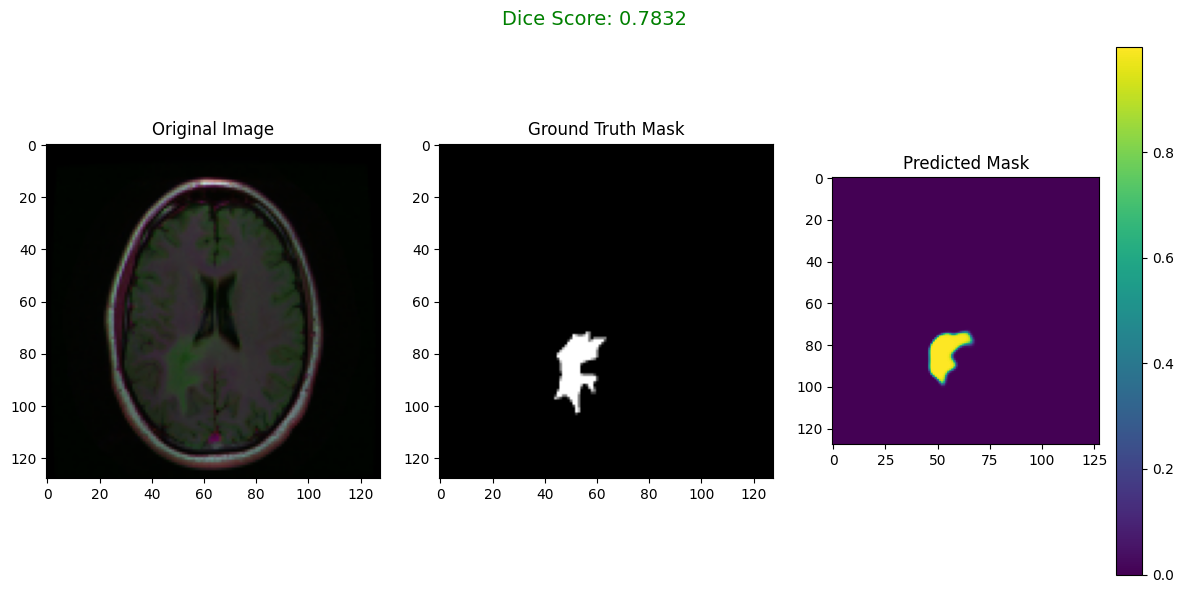

In [19]:
# عرض النتائج
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(sample_img)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(sample_mask.squeeze(), cmap='gray')
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
plt.imshow(pred_mask.squeeze(), cmap='viridis')
plt.title('Predicted Mask')
plt.colorbar()

plt.suptitle(f'Dice Score: {dice_score:.4f}', fontsize=14, color='green')
plt.tight_layout()
plt.show()

In [20]:
segmentation_model = load_model("best_model.h5", compile=False)
segmentation_model.save("Segmentation_model.keras")